# Aim
Check whether DECD param give consistent fidelities with Qutip Simulations

# Imports

In [1]:
import sys 
sys.path.append('C:\\Users\\Eesh Gupta\\Documents\\RU Research\\Chakram')


In [2]:
# for param file 
#%%
# note: timestamp can't use "/" character for h5 saving.
TIMESTAMP_FORMAT = "%Y-%m-%d %H:%M:%S"
END_OPT_STRING = "\n" + "=" * 60 + "\n"
import numpy as np
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # supress warnings
import h5py

# print(
#     "\nNeed tf version 2.3.0 or later. Using tensorflow version: "
#     + tf.__version__
#     + "\n"
# )
import ECD_control.ECD_optimization.tf_quantum as tfq
from ECD_control.ECD_optimization.visualization import VisualizationMixin
import qutip as qt
import datetime
import time

In [3]:
# for pulse file
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from scipy.optimize import fmin



# Pulse

In [4]:
from DECD_pulse import *

In [5]:
# Import Data 
fname = 'Test_00_10_May23.txt'
import numpy as np
b_file = open(fname, "r")
params = np.loadtxt(b_file)
print(params)

[[-1.39062333 -1.5805974  -2.60015082 -0.57049859]
 [-3.3814621   1.74659038  0.69830352 -1.70698524]
 [-0.5962196   0.33704624  0.21858694 -0.04420422]
 [-1.88043606  0.7057426   0.15740366 -0.97481567]
 [ 0.         -2.37121439  1.32579303  1.89272666]
 [ 0.00841689  3.13234544 -3.14032674  0.0129838 ]
 [ 1.57079625  1.57079625  1.57079625  1.57079625]]


In [6]:
import cmath
betas = np.asarray([complex(params[0][i], params[1][i]) for i in range(len(params[0]))])
gammas = np.asarray([complex(params[2][i], params[3][i]) for i in range(len(params[0]))])
phis = params[4]
thetas = params[5]

#the parameters in our circuit. Can be user defined, or loaded from the result of an ECD optimization.

print('betas:' + str(betas))
print('gammas:' + str(gammas))
print('phis:' + str(phis))
print('thetas:' + str(thetas))

betas:[-1.39062333-3.3814621j  -1.5805974 +1.74659038j -2.60015082+0.69830352j
 -0.57049859-1.70698524j]
gammas:[-0.5962196 -1.88043606j  0.33704624+0.7057426j   0.21858694+0.15740366j
 -0.04420422-0.97481567j]
phis:[ 0.         -2.37121439  1.32579303  1.89272666]
thetas:[ 0.00841689  3.13234544 -3.14032674  0.0129838 ]


In [7]:
#Our cavity and qubit. When using pulse construction on the FPGA, these objects can be loaded, and 
#Here, we are making a "FakeCavity" and a "FakeQubit" with parameters found from experimental calibrations.

storage1_params = {
        "chi_kHz": -33, #dispersive shift
        "chi_prime_Hz": 0, #second order dispersive shift
        "Ks_Hz": 0, #Kerr correction not yet implemented.
        "epsilon_m_MHz": 400, #largest oscillator drive amplitude in MHz (max|epsilon|)
        "unit_amp": 0.01, #DAC unit amp of gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement sigma
        "chop": 4, #oscillator displacement chop (number of stds. to include in gaussian pulse)
    }
storage2_params = {
        "chi_kHz": -33, #dispersive shift
        "chi_prime_Hz": 0, #second order dispersive shift
        "Ks_Hz": 0, #Kerr correction not yet implemented.
        "epsilon_m_MHz": 400, #largest oscillator drive amplitude in MHz (max|epsilon|)
        "unit_amp": 0.01, #DAC unit amp of gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement sigma
        "chop": 4, #oscillator displacement chop (number of stds. to include in gaussian pulse)
    }
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.

#calculating conversion between qubit DAC units and MHz (Omega)
pi = rotate(np.pi, phi=0, sigma=qubit_params['sigma'], chop=qubit_params['chop'], dt=1)
Omega_m = np.real(np.max(pi))/qubit_params['unit_amp']

#creating the "Fake storage" and "Fake qubit"
storage1 = FakeStorage(**storage1_params)
storage2 = FakeStorage(**storage2_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD1 = 30
alpha_CD2 = 30
#Small delay to insert between oscillator and qubit pulses
buffer_time = 4

In [8]:
#From these calibrations, the storage and qubit objects calculate the
#conversion between DAC amplitude, and drive amplitude in MHz.
#so, [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz 
#and [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz.
#These parameters also represent the maximum drive amplitude,
#since the DAC max amplitude is 1 (assuming amplifiers don't saturate.)
print('Maximum oscillator 1 drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage1.epsilon_m_MHz)
print('Maximum oscillator 2 drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage2.epsilon_m_MHz)
print('Maximum qubit drive amplitude: |Omega|/2*pi < %.3f MHz' % qubit.Omega_m_MHz)


Maximum oscillator 1 drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum oscillator 2 drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum qubit drive amplitude: |Omega|/2*pi < 40.468 MHz


In [9]:
#generating the conditional displacement circuit.
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a displacement
pulse_dict = conditional_displacement_circuit1(betas, gammas, phis, thetas, storage1, storage2, qubit,
                     alpha_CD1, alpha_CD2 ,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)
cavity1_dac_pulse, cavity2_dac_pulse, qubit_dac_pulse, = pulse_dict['cavity1_dac_pulse'], pulse_dict['cavity2_dac_pulse'], pulse_dict['qubit_dac_pulse']



C:\Users\Eesh Gupta\anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [18]:
cavity1_dac_pulse_GHz = (2*np.pi)*(10**(-3))*storage1.epsilon_m_MHz*cavity1_dac_pulse #convert from DAC to Mhz to Ghz
cavity2_dac_pulse_GHz = (2*np.pi)*(10**(-3))*storage2.epsilon_m_MHz*cavity2_dac_pulse #convert from DAC to Mhz to Ghz
qubit_dac_pulse_GHz = (2*np.pi)*10**(-3)*qubit.Omega_m_MHz*qubit_dac_pulse #convert from DAC to Mhz to Ghz

In [19]:
cavity2_dac_pulse_GHz_null = np.array([0.0 + 0.0j for i in range(len(cavity2_dac_pulse_GHz))])

Text(0, 0.5, 'Ghz')

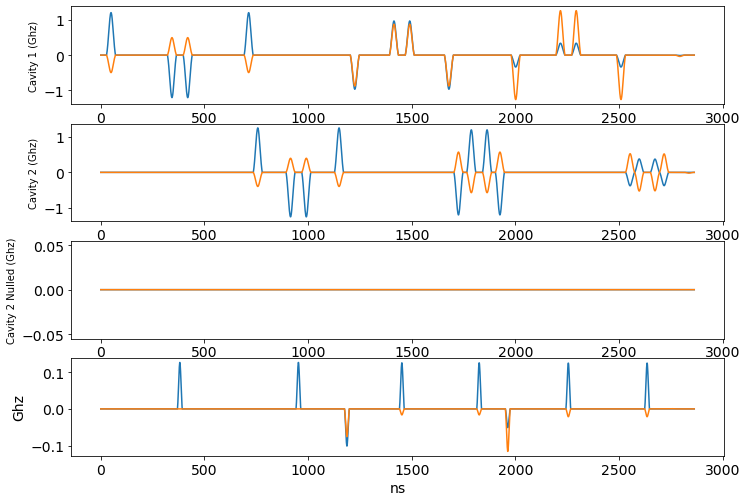

In [20]:
#plotting the pulse in GHz
fig, axs = plt.subplots(4,1)
axs[0].plot(np.real(cavity1_dac_pulse_GHz))
axs[0].plot(np.imag(cavity1_dac_pulse_GHz))
axs[1].plot(np.real(cavity2_dac_pulse_GHz))
axs[1].plot(np.imag(cavity2_dac_pulse_GHz))
axs[2].plot(np.real(cavity2_dac_pulse_GHz_null))
axs[2].plot(np.imag(cavity2_dac_pulse_GHz_null))
axs[0].set_ylabel('Cavity 1 (Ghz)', fontsize = 10)
axs[1].set_ylabel('Cavity 2 (Ghz)', fontsize = 10)
axs[2].set_ylabel('Cavity 2 Nulled (Ghz)', fontsize = 10)
axs[3].plot(np.real(qubit_dac_pulse_GHz))
axs[3].plot(np.imag(qubit_dac_pulse_GHz))
plt.xlabel('ns')
plt.ylabel('Ghz')

In [21]:
def alpha_from_epsilon_nonlinear_finite_difference(
    epsilon_array, delta=0, alpha_init=0 + 0j):
    dt = 1
    alpha = np.zeros_like(epsilon_array)
    alpha[0] = alpha_init
    alpha[1] = alpha_init
    for j in range(1, len(epsilon_array) - 1):
        alpha[j + 1] = (
                2*
                 dt
                * (
                    -1j * delta# * alpha[j]
                    #- 2j * Ks * np.abs(alpha[j]) ** 2 * alpha[j]
                    #- (kappa / 2.0) * alpha[j]
                    - 1j * epsilon_array[j]
                )
                + alpha[j - 1])
    return alpha

In [22]:
alpha1 = alpha_from_epsilon_nonlinear_finite_difference(
    epsilon_array =cavity1_dac_pulse_GHz , delta=0, alpha_init=0 + 0j)
alpha1_star = np.conjugate(alpha1)

In [23]:
alpha2 = alpha_from_epsilon_nonlinear_finite_difference(
    epsilon_array =cavity2_dac_pulse_GHz_null , delta=0, alpha_init=0 + 0j)
alpha2_star = np.conjugate(alpha2)

Text(0, 0.5, 'alpha2')

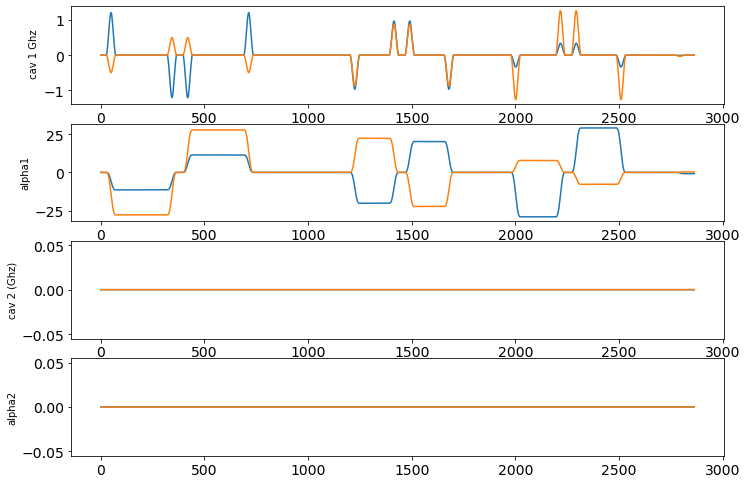

In [25]:
fig, axs = plt.subplots(4,1)
axs[0].plot(np.real(cavity1_dac_pulse_GHz))
axs[0].plot(np.imag(cavity1_dac_pulse_GHz))
axs[0].set_ylabel(' cav 1 Ghz', fontsize = 10)


axs[1].plot(np.real(alpha1))
axs[1].plot(np.imag(alpha1))
axs[1].set_ylabel('alpha1', fontsize = 10)

axs[2].plot(np.real(cavity2_dac_pulse_GHz_null))
axs[2].plot(np.imag(cavity2_dac_pulse_GHz_null))
axs[2].set_ylabel('cav 2 (Ghz)', fontsize = 10)

axs[3].plot(np.real(alpha2))
axs[3].plot(np.imag(alpha2))
axs[3].set_ylabel('alpha2', fontsize = 10)

# axs[2].plot(np.real(alpha1_star))
# axs[2].plot(np.imag(alpha1_star))
# axs[2].set_ylabel('alpha1_star', fontsize = 10)
# plt.xlabel('ns')



# axs[2].plot(np.real(alpha2_star))
# axs[2].plot(np.imag(alpha2_star))
# axs[2].set_ylabel('alpha2_star', fontsize = 10)
# plt.xlabel('ns')

# Qutip Simulation

In [26]:
from qutip import *
from qutip.control import *
from math import *

In [27]:
T = len(cavity1_dac_pulse)
times = np.linspace(0, T, T) #1ns timesteps

In [28]:
n_c1 = 5  #number of levels in cavity
n_c2 = 5  #number of levels in cavity
n_q = 2 #number of levels in qubit

#N = 1 #target cavity state

omega_c1  = 5.26 *2*pi   #frequencies in GHz
omega_c2 = 5.26 *2*pi   #frequencies in GHz
omega_q = 6.65*2*pi
#K = -3.7*(10**(-6))*2*pi #cavity nonlinearity

#photon depenedent number shifts
chi1 = storage1_params["chi_kHz"]*2*pi*(10**(-6)) #linear
chi1_ = storage1_params["chi_prime_Hz"]*(10**(-9)) #quadratic
chi2 = storage2_params["chi_kHz"]*2*pi*(10**(-6)) #linear
chi2_ = storage2_params["chi_prime_Hz"]*(10**(-9)) #quadratic

##mode to mode coupling 
eta = 0#10**(-6)

Assuming both modes have same number of levels

In [29]:
# Creating identity, annhilitation/creation, num operators 
identity_q = qeye(n_q)
identity_c = qeye(n_c1)

a_q = destroy(n_q)
a_c = destroy(n_c1)

adag_q = create(n_q)
adag_c = create(n_c2)

num_q = num(n_q)
num_c =  num(n_c1)


c_ops = []

tlist = times




In [30]:
# Displace Frame hammy
H0_disp = ((chi1/2)*tensor(sigmaz(), num_c, identity_c) # first mode -qubit
            +
          (chi2/2)*tensor(sigmaz(), identity_c, num_c) # 2nd mode - qubit
           +
          (eta)*tensor(identity_q, num_c, num_c)) # MODE-MODE

In [31]:
#for time dep hammy
def mult(a,b):
    '''
    Elementwise multiplication of two lists
    '''
    if len(a) != len(b):
        print('Error with mult: lists must be of same length')
        return []
    return [a[i]*b[i] for i in range(len(a)) ]
    

In [32]:
a = alpha2
b = alpha2_star

In [33]:
# prepping time depedent hammys
alpha1_sq =np.real( [np.real(i)**2 + np.imag(i)**2 for i in alpha1])
alpha2_sq =np.real( [np.real(i)**2 + np.imag(i)**2 for i in alpha2])
alpha1_times_2 = mult(alpha1, alpha2)
alpha1star_times_2 = mult(alpha1_star, alpha2)


H = [H0_disp,
     #Qubit drive
    [tensor(a_q, identity_c, identity_c), np.conjugate(qubit_dac_pulse_GHz)], 
     [tensor(adag_q, identity_c, identity_c), qubit_dac_pulse_GHz],
     
     # Desired Displacement term from qubit-mode1 coupling
     [(chi1/2)*tensor(sigmaz(), a_c, identity_c), alpha1_star],  
     [(chi1/2)*tensor(sigmaz(), adag_c, identity_c), alpha1],
     
     # Desired Displacement term from qubit-mode2 coupling
     [(chi2/2)*tensor(sigmaz(), a_c, identity_c), b],  
     [(chi2/2)*tensor(sigmaz(), adag_c, identity_c), a],
     
     # UnDesired Displacement term from mode-mode coupling (no disp^2)
     
#      [(eta)*tensor(identity_q, a_c, num_c), alpha1_star],  
#      [(eta)*tensor(identity_q, adag_c, num_c), alpha1],
#      [(eta)*tensor(identity_q, num_c, a_c), alpha2_star],  
#      [(eta)*tensor(identity_q, num_c, adag_c), alpha2],
     
#      [(eta)*tensor(identity_q, a_c, a_c), np.conjugate(alpha1_times_2)],  
# #      [(eta)*tensor(identity_q, a_c, adag_c), alpha1star_times_2],
#      [(eta)*tensor(identity_q, adag_c, a_c), np.conjugate(alpha1star_times_2)],  
# #     [(eta)*tensor(identity_q, adag_c, adag_c), alpha1_times_2],
     
     # Undesired alpha^2 terms from frequency and mode-mode displacement
#       [(chi1/2)*tensor(sigmaz(), identity_c, identity_c), alpha1_sq],
#      [(chi2/2)*tensor(sigmaz(), identity_c, identity_c), alpha2_sq],
#      [(eta)*tensor(identity_q, identity_c, num_c), alpha1_sq],
#      [(eta)*tensor(identity_q, identity_c, num_c), alpha2_sq]
     ]

In [34]:
psi0 = tensor(basis(n_q,0), basis(n_c1,0), basis(n_c2,0))
opts = Options(store_states=True, store_final_state=True, nsteps = 5000)
output = mesolve(H, psi0 , times, c_ops, [], options =opts)
rho = output.states[-1]

In [35]:
target_state = tensor(basis(n_q,1), basis(n_c1, 1), basis(n_c2, 0))
fidelity = rho.overlap(target_state)
fid = np.sqrt(fidelity.real**2 + fidelity.imag**2)
print('Fidelity is '+ str(fid))

Fidelity is 0.011001422358832733


In [36]:
target_state = tensor(basis(n_q,0), basis(n_c1, 1), basis(n_c2, 0))
fidelity = rho.overlap(target_state)
fid = np.sqrt(fidelity.real**2 + fidelity.imag**2)
print('Fidelity is '+ str(fid))

Fidelity is 0.3594351253408782


# Visualization

In [37]:
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plot.rcParams.update(params)

In [38]:
def plot_populations(output, figname):
    '''
    Given output of mesolve, outputs populations with qubit as ground
    '''
    fig = plt.figure(figsize=(10,8))
    probs = []
    times = [k for k in range(len(output.states))]
    max_num_levels = 2 # to be shown on the plot
    
    #qubit grounded
    for i in range(max_num_levels):
        for j in range(max_num_levels):
            target = tensor(basis(n_q,0), basis(n_c1, i), basis(n_c2, j))
            pops = []
            for k in range(len(output.states)): 
                z = target.overlap(output.states[k])
                pops.append(z.real**2 + z.imag**2)
            plt.plot(times, pops, label = '|g,'+str(i)+',' + str(j)+'>')
    
    #qubit excited
    for i in range(max_num_levels):
        for j in range(max_num_levels):
            target = tensor(basis(n_q,1), basis(n_c1, i), basis(n_c2, j))
            pops = []
            for k in range(len(output.states)): 
                z = target.overlap(output.states[k])
                pops.append(z.real**2 + z.imag**2)
            plt.plot(times, pops, label = '|e,'+str(i)+',' + str(j)+'>')
            
    plt.xlabel("Time (ns)", fontsize = 14)
    plt.ylabel("Populations", fontsize = 14)
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
#     plt.legend(prop={'size': 20},  fontsize = 8, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)   
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend()
    fig.savefig(figname, dpi = 1000)

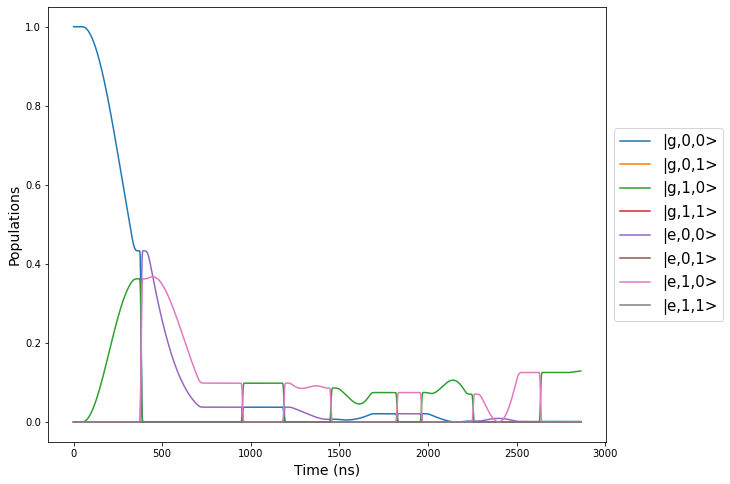

In [39]:
plot_populations(output, 'g00 to g01_eta1Hz.png')